# Spam Email Detection  Model

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mail_data.csv to mail_data.csv


In [ ]:
data = pd.read_csv('mail_data.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
 #Check the shape
print("Dataset Shape:", data.shape)


Dataset Shape: (5572, 2)


In [ ]:
# Check the column names
print(data.columns)


Index(['Category', 'Message'], dtype='object')


In [ ]:
# Remove any leading/trailing spaces from column names
# f the column names have extra spaces or special characters, you can clean them up as follows:
data.columns = data.columns.str.strip()


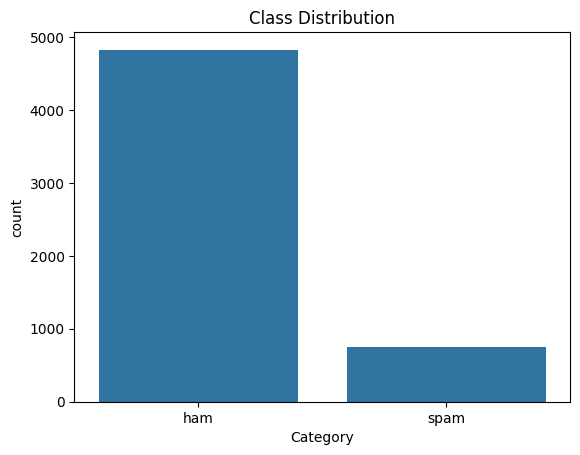

In [ ]:
# Plot class distribution
sns.countplot(x='Category', data=data)
plt.title("Class Distribution")
plt.show()

# Balancing the Dataset

In [ ]:
# Separate spam and ham
ham_msg = data[data['Category'] == 'ham']  # Assuming 'ham' indicates non-spam
spam_msg = data[data['Category'] == 'spam']  # Assuming 'spam' indicates spam messages

# Downsample majority class (ham messages) to match the number of spam messages
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine the two datasets and shuffle them
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)




### Plot new class distribution

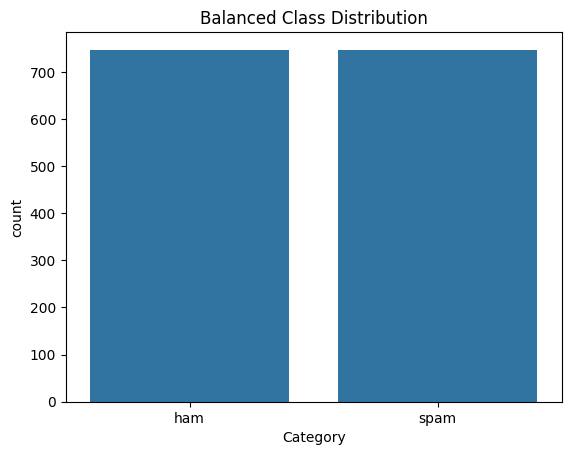

In [ ]:
# Plot new class distribution
sns.countplot(x='Category', data=balanced_data)
plt.title("Balanced Class Distribution")
plt.show()

# Text Preprocessing

In [ ]:
import string
from nltk.corpus import stopwords

# Remove punctuations
def remove_punctuations(text):
    punctuations_list = string.punctuation
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.lower().split() if word not in stop_words])

# Apply transformations on the 'Message' column
balanced_data['Message'] = balanced_data['Message'].str.replace('Subject:', '')  # Remove 'Subject:' if present
balanced_data['Message'] = balanced_data['Message'].apply(remove_punctuations)  # Remove punctuation
balanced_data['Message'] = balanced_data['Message'].apply(remove_stopwords)  # Remove stopwords



# Visualize Text with WordCloud

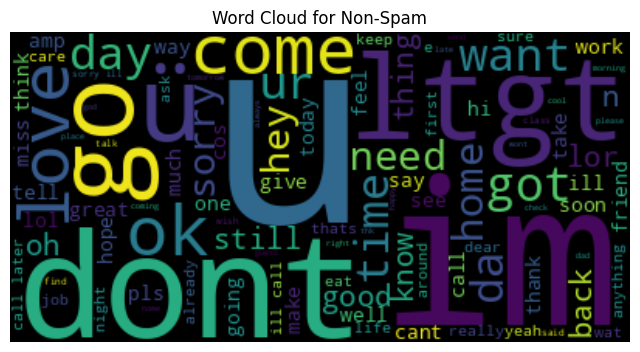

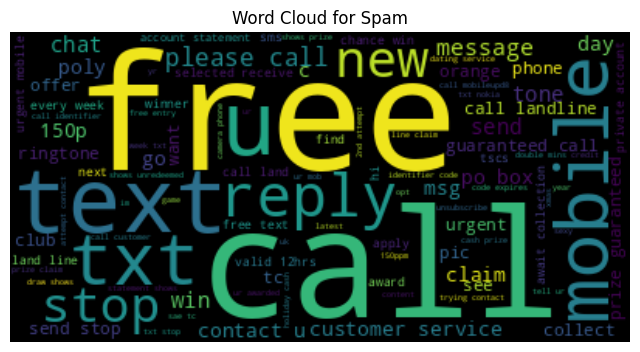

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud
def plot_word_cloud(data, title):
    corpus = " ".join(data)  # Join all messages into a single string
    wordcloud = WordCloud(background_color='black', max_words=100).generate(corpus)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {title}")
    plt.axis('off')
    plt.show()

# Plot word clouds for non-spam (ham) and spam messages
plot_word_cloud(balanced_data[balanced_data['Category'] == 'ham']['Message'], "Non-Spam")
plot_word_cloud(balanced_data[balanced_data['Category'] == 'spam']['Message'], "Spam")


# Convert Text to Vectors

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:

# Convert 'ham'/'spam' to 0/1
balanced_data['label'] = balanced_data['Category'].apply(lambda x: 1 if x == 'spam' else 0)

# Split dataset
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['Message'], balanced_data['label'], test_size=0.2, random_state=42
)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences
max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')


#### Data after converted :

In [ ]:
# Print the first 5 rows of tokenized and padded data
print("Tokenized and padded sequences (first 5 examples):")
print(train_sequences[:5])  # Print first 5 tokenized sequences from the training data

# Optionally, if you want to see the corresponding words (using the tokenizer's word index)
word_index = tokenizer.word_index

# Function to decode a sequence back into words
def decode_sequence(sequence):
    return ' '.join([word for word, index in word_index.items() if index in sequence])

# Decode the first 5 tokenized sequences back to words
decoded_train_sequences = [decode_sequence(seq) for seq in train_sequences[:5]]
print("\nDecoded tokenized sequences (first 5 examples):")
for seq in decoded_train_sequences:
    print(seq)


Tokenized and padded sequences (first 5 examples):
[[ 449  198   46  330    7  629  808  218  808 1765  331  527    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  87   36    1  157    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0


# Build the LSTM Model

In [ ]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#Train and Evaluate the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5)

# Train the model
history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20, batch_size=32,
    callbacks=[es, lr]
)



Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4843 - loss: 0.6933 - val_accuracy: 0.4849 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4909 - loss: 0.6934 - val_accuracy: 0.4849 - val_loss: 0.6934 - learning_rate: 5.0000e-04
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4804 - loss: 0.6934 - val_accuracy: 0.4849 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.4913 - loss: 0.6932 - val_accuracy: 0.4849 - val_loss: 0.6933 - learning_rate: 2.5000e-04


##### Evaluate the model performance

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5028 - loss: 0.6931
Test Loss: 0.6933442950248718, Test Accuracy: 0.48494982719421387


#Visualize Training Performance

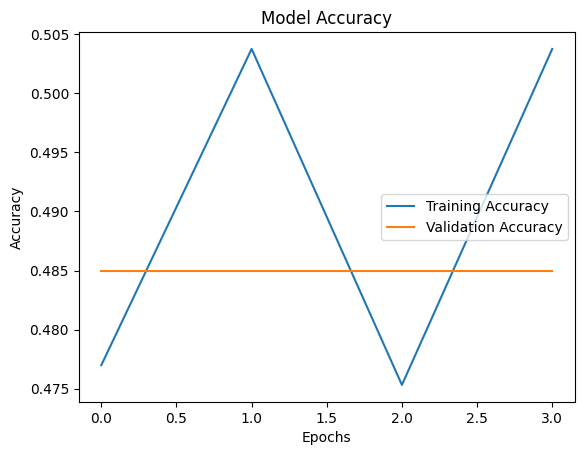

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add titles and labels
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Show legend
plt.legend()

# Display the plot
plt.show()
